In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import math
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Set random seed for reproducibility
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters
batch_size = 128
num_epochs = 20
learning_rate = 3e-4
weight_decay = 1e-4

image_size = 32
patch_size = 4
num_classes = 10
dim = 256  # Total dimension
proj_dim = 192  # Dimension for patch projections (3d/4)
pos_dim = 64  # Dimension for positional encodings (d/4)
depth = 6
heads = 8
mlp_dim = 512
channels = 3
dropout = 0.1

# Data Loading and Preprocessing
transform_train = transforms.Compose([
                transforms.Resize((image_size, image_size)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(10),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                transforms.ToTensor(),
                transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2470, 0.2435, 0.2616])
            ])

transform_test = transforms.Compose([
                transforms.Resize((image_size, image_size)),
                transforms.ToTensor(),
                transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2470, 0.2435, 0.2616])
            ])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


# Sinusoidal Positional Encoding
class SinCosPositionalEncoding(nn.Module):
    def __init__(self, dim, n_position=200):
        super(SinCosPositionalEncoding, self).__init__()
        self.dim = dim
        
        # Create constant positional encoding matrix
        pe = torch.zeros(n_position, dim)
        position = torch.arange(0, n_position).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, dim, 2).float() * -(math.log(10000.0) / dim))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        return x + self.pe[:, :x.size(1)].to(x.device)

# 2D Sinusoidal Positional Encoding for Vision Transformer
class SinCos2DPositionalEncoding(nn.Module):
    def __init__(self, dim, h=8, w=8):
        super(SinCos2DPositionalEncoding, self).__init__()
        
        # Create 2D positional encoding
        pos_enc = torch.zeros(h, w, dim)
        
        # Separate channels for width and height dimensions
        dim_h = dim // 2
        dim_w = dim // 2
        
        # Position indices
        y_pos = torch.arange(h).unsqueeze(1).repeat(1, w).reshape(h, w)
        x_pos = torch.arange(w).unsqueeze(0).repeat(h, 1).reshape(h, w)
        
        # Create division term for computing positional encoding values
        div_term_h = torch.exp(torch.arange(0, dim_h, 2).float() * -(math.log(10000.0) / dim_h))
        div_term_w = torch.exp(torch.arange(0, dim_w, 2).float() * -(math.log(10000.0) / dim_w))
        
        # Apply sin and cos to odd and even indices
        for i in range(0, dim_h, 2):
            if i < dim_h:
                pos_enc[:, :, i] = torch.sin(y_pos.float() * div_term_h[i//2])
                pos_enc[:, :, i+1] = torch.cos(y_pos.float() * div_term_h[i//2])
            
        for i in range(0, dim_w, 2):
            if i + dim_h < dim:
                pos_enc[:, :, i+dim_h] = torch.sin(x_pos.float() * div_term_w[i//2])
                pos_enc[:, :, i+dim_h+1] = torch.cos(x_pos.float() * div_term_w[i//2])
        
        # Flatten the positional encoding to match the sequence format (h*w, dim)
        pos_enc = pos_enc.reshape(h * w, dim)
        
        # Add extra position for class token
        cls_pos_enc = torch.zeros(1, dim)
        pos_enc = torch.cat([cls_pos_enc, pos_enc], dim=0)
        
        # Register as buffer (persistent but not model parameter)
        self.register_buffer('pos_enc', pos_enc.unsqueeze(0))
        self.cls_pos_enc = cls_pos_enc.unsqueeze(0)

        
    def forward(self, x):
        return x + self.pos_enc

# 2D Sinusoidal Positional Encoding Generator
class SinCos2DPositionalEncodingAppend:
    def __init__(self, pos_dim, h, w):
        """
        Generate 2D sinusoidal positional encodings for image patches
        
        Args:
            pos_dim: Dimension of the positional encoding vector
            h: Number of patches in height dimension
            w: Number of patches in width dimension
        """
        self.pos_dim = pos_dim
        self.h = h
        self.w = w
        
        # Initialize positional encodings
        self.generate_encodings()
        
    def generate_encodings(self):
        # Create position indices
        y_pos = torch.arange(self.h).unsqueeze(1).repeat(1, self.w).reshape(self.h, self.w)
        x_pos = torch.arange(self.w).unsqueeze(0).repeat(self.h, 1).reshape(self.h, self.w)
        
        # Split dimensions for height and width
        dim_h = self.pos_dim // 2
        dim_w = self.pos_dim - dim_h  # In case pos_dim is odd
        
        # Division terms for computing positional encoding
        div_term_h = torch.exp(torch.arange(0, dim_h, 2).float() * -(math.log(10000.0) / dim_h))
        div_term_w = torch.exp(torch.arange(0, dim_w, 2).float() * -(math.log(10000.0) / dim_w))
        
        # Create positional encoding tensor
        pos_enc = torch.zeros(self.h, self.w, self.pos_dim)
        
        # Apply sin and cos to encode height positions
        for i in range(0, dim_h, 2):
            if i < dim_h:
                pos_enc[:, :, i] = torch.sin(y_pos.float() * div_term_h[i//2])
                if i + 1 < dim_h:
                    pos_enc[:, :, i+1] = torch.cos(y_pos.float() * div_term_h[i//2])
        
        # Apply sin and cos to encode width positions
        for i in range(0, dim_w, 2):
            if i + dim_h < self.pos_dim:
                pos_enc[:, :, i+dim_h] = torch.sin(x_pos.float() * div_term_w[i//2])
                if i + dim_h + 1 < self.pos_dim:
                    pos_enc[:, :, i+dim_h+1] = torch.cos(x_pos.float() * div_term_w[i//2])
        
        # Reshape to (h*w, pos_dim)
        self.pos_enc = pos_enc.reshape(self.h * self.w, self.pos_dim)
        
        # Create a special positional encoding for the class token
        self.cls_pos_enc = torch.zeros(1, self.pos_dim)



# Multi-head Self Attention
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, dim, heads=8, dropout=0.1):
        super(MultiHeadSelfAttention, self).__init__()
        self.heads = heads
        self.head_dim = dim // heads
        self.scale = self.head_dim ** -0.5
        
        self.to_qkv = nn.Linear(dim, dim * 3, bias=False)
        self.to_out = nn.Linear(dim, dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        b, n, c = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: t.reshape(b, n, self.heads, self.head_dim).transpose(1, 2), qkv)
        
        # Attention
        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale
        attn = F.softmax(dots, dim=-1)
        attn = self.dropout(attn)
        
        # Apply attention to v
        out = torch.matmul(attn, v)
        out = out.transpose(1, 2).reshape(b, n, c)
        out = self.to_out(out)
        return out

# MLP Block
class MLP(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.1):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    
    def forward(self, x):
        return self.net(x)

# Transformer Encoder Block
class TransformerBlock(nn.Module):
    def __init__(self, dim, heads, mlp_dim, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = MultiHeadSelfAttention(dim, heads, dropout)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = MLP(dim, mlp_dim, dropout)
        
    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

# Vision Transformer with Concatenated Positional Encodings
class ViT(nn.Module):
    def __init__(
        self, 
        image_size, 
        patch_size, 
        num_classes, 
        dim, 
        proj_dim,
        pos_dim,
        depth, 
        heads, 
        mlp_dim, 
        channels=3, 
        dropout=0.1
    ):
        super(ViT, self).__init__()
        assert image_size % patch_size == 0, 'Image size must be divisible by patch size'
        assert dim == proj_dim + pos_dim, 'proj_dim + pos_dim must equal dim'
        
        self.num_patches = (image_size // patch_size) ** 2
        patch_dim = channels * patch_size ** 2
        
        self.patch_size = patch_size
        self.h_patches = image_size // patch_size
        self.w_patches = image_size // patch_size
        
        # Patch embedding - project to lower dimension (3d/4)
        self.to_patch_embedding = nn.Linear(patch_dim, proj_dim)
        
        # Class token
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        
        # Generate positional encodings
        self.pos_encoder = SinCos2DPositionalEncoding(pos_dim, self.h_patches, self.w_patches)
        
        # Register positional encodings as buffers
        self.register_buffer('patch_pos_enc', self.pos_encoder.pos_enc)
        self.register_buffer('cls_pos_enc', self.pos_encoder.cls_pos_enc)
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
        # Transformer blocks
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(dim, heads, mlp_dim, dropout) for _ in range(depth)
        ])
        
        # MLP Head
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )
        
    def forward(self, img):
        # Get batch size and reshape image into patches
        b, c, h, w = img.shape
        
        # Split image into patches
        patches = img.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(b, c, -1, self.patch_size, self.patch_size)
        patches = patches.permute(0, 2, 1, 3, 4).contiguous().view(b, -1, c * self.patch_size * self.patch_size)
        # Project patches to embedding dimension (3d/4)
        x = self.to_patch_embedding(patches)  # (b, num_patches, proj_dim)
        # print(x.shape)
        # Get positional encodings for all patches (d/4)
        # pos_enc = self.patch_pos_enc.repeat(b, 1, 1)  # (b, num_patches, pos_dim)
        pos_enc = self.pos_encoder.pos_enc[:, 1:, :].repeat(b, 1, 1)
        # Concatenate embeddings with positional encodings
        x = torch.cat([x, pos_enc], dim=2)  # (b, num_patches, dim)
        
        # Add class token (already of full dimension)
        cls_tokens = self.cls_token.expand(b, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)  # (b, 1+num_patches, dim)
        
        # Apply dropout
        x = self.dropout(x)
        
        # Apply transformer blocks
        for block in self.transformer_blocks:
            x = block(x)
        
        # Get the class token representation
        x = x[:, 0]
        
        # MLP head
        return self.mlp_head(x)

# Create model, optimizer, and loss function
model = ViT(
    image_size=image_size,
    patch_size=patch_size,
    num_classes=num_classes,
    dim=dim,
    proj_dim=proj_dim,
    pos_dim=pos_dim,
    depth=depth,
    heads=heads,
    mlp_dim=mlp_dim,
    channels=channels,
    dropout=dropout
).to(device)

Using device: cuda


In [2]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 3170762


Using device: cuda


Epoch 1/20: 100%|██████████| 391/391 [00:25<00:00, 15.28it/s, loss=1.67, acc=38.6]


Test Loss: 1.3053, Test Acc: 53.16%
Epoch 1/20: Train Loss: 1.6674, Train Acc: 38.63%, Test Loss: 1.3053, Test Acc: 53.16%


Epoch 2/20: 100%|██████████| 391/391 [00:23<00:00, 16.41it/s, loss=1.26, acc=54.6]


Test Loss: 1.1081, Test Acc: 60.72%
Epoch 2/20: Train Loss: 1.2555, Train Acc: 54.61%, Test Loss: 1.1081, Test Acc: 60.72%


Epoch 3/20: 100%|██████████| 391/391 [00:23<00:00, 16.49it/s, loss=1.12, acc=59.9]


Test Loss: 1.0224, Test Acc: 63.39%
Epoch 3/20: Train Loss: 1.1228, Train Acc: 59.87%, Test Loss: 1.0224, Test Acc: 63.39%


Epoch 4/20: 100%|██████████| 391/391 [00:23<00:00, 16.51it/s, loss=1.03, acc=63]  


Test Loss: 0.9676, Test Acc: 65.13%
Epoch 4/20: Train Loss: 1.0350, Train Acc: 63.04%, Test Loss: 0.9676, Test Acc: 65.13%


Epoch 5/20: 100%|██████████| 391/391 [00:23<00:00, 16.47it/s, loss=0.971, acc=65.1]


Test Loss: 0.9129, Test Acc: 67.24%
Epoch 5/20: Train Loss: 0.9713, Train Acc: 65.11%, Test Loss: 0.9129, Test Acc: 67.24%


Epoch 6/20: 100%|██████████| 391/391 [00:23<00:00, 16.47it/s, loss=0.921, acc=67.3]


Test Loss: 0.9225, Test Acc: 67.15%
Epoch 6/20: Train Loss: 0.9211, Train Acc: 67.34%, Test Loss: 0.9225, Test Acc: 67.15%


Epoch 7/20: 100%|██████████| 391/391 [00:23<00:00, 16.41it/s, loss=0.868, acc=69.2]


Test Loss: 0.8421, Test Acc: 70.07%
Epoch 7/20: Train Loss: 0.8677, Train Acc: 69.24%, Test Loss: 0.8421, Test Acc: 70.07%


Epoch 8/20: 100%|██████████| 391/391 [00:23<00:00, 16.47it/s, loss=0.823, acc=70.7]


Test Loss: 0.8205, Test Acc: 70.77%
Epoch 8/20: Train Loss: 0.8226, Train Acc: 70.73%, Test Loss: 0.8205, Test Acc: 70.77%


Epoch 9/20: 100%|██████████| 391/391 [00:23<00:00, 16.59it/s, loss=0.777, acc=72.4]


Test Loss: 0.8052, Test Acc: 71.32%
Epoch 9/20: Train Loss: 0.7768, Train Acc: 72.42%, Test Loss: 0.8052, Test Acc: 71.32%


Epoch 10/20: 100%|██████████| 391/391 [00:23<00:00, 16.51it/s, loss=0.738, acc=73.8]


Test Loss: 0.7549, Test Acc: 73.64%
Epoch 10/20: Train Loss: 0.7377, Train Acc: 73.80%, Test Loss: 0.7549, Test Acc: 73.64%


Epoch 11/20: 100%|██████████| 391/391 [00:23<00:00, 16.37it/s, loss=0.701, acc=75]  


Test Loss: 0.7234, Test Acc: 74.40%
Epoch 11/20: Train Loss: 0.7012, Train Acc: 75.00%, Test Loss: 0.7234, Test Acc: 74.40%


Epoch 12/20: 100%|██████████| 391/391 [00:23<00:00, 16.57it/s, loss=0.659, acc=76.5]


Test Loss: 0.7150, Test Acc: 74.80%
Epoch 12/20: Train Loss: 0.6593, Train Acc: 76.47%, Test Loss: 0.7150, Test Acc: 74.80%


Epoch 13/20: 100%|██████████| 391/391 [00:23<00:00, 16.51it/s, loss=0.619, acc=77.8]


Test Loss: 0.7112, Test Acc: 75.24%
Epoch 13/20: Train Loss: 0.6193, Train Acc: 77.79%, Test Loss: 0.7112, Test Acc: 75.24%


Epoch 14/20: 100%|██████████| 391/391 [00:23<00:00, 16.42it/s, loss=0.592, acc=78.9]


Test Loss: 0.6786, Test Acc: 76.34%
Epoch 14/20: Train Loss: 0.5916, Train Acc: 78.93%, Test Loss: 0.6786, Test Acc: 76.34%


Epoch 15/20: 100%|██████████| 391/391 [00:23<00:00, 16.60it/s, loss=0.557, acc=80.4]


Test Loss: 0.6775, Test Acc: 76.35%
Epoch 15/20: Train Loss: 0.5574, Train Acc: 80.38%, Test Loss: 0.6775, Test Acc: 76.35%


Epoch 16/20: 100%|██████████| 391/391 [00:23<00:00, 16.48it/s, loss=0.534, acc=81.2]


Test Loss: 0.6745, Test Acc: 76.78%
Epoch 16/20: Train Loss: 0.5340, Train Acc: 81.18%, Test Loss: 0.6745, Test Acc: 76.78%


Epoch 17/20: 100%|██████████| 391/391 [00:23<00:00, 16.38it/s, loss=0.51, acc=81.9] 


Test Loss: 0.6673, Test Acc: 77.03%
Epoch 17/20: Train Loss: 0.5105, Train Acc: 81.90%, Test Loss: 0.6673, Test Acc: 77.03%


Epoch 18/20: 100%|██████████| 391/391 [00:23<00:00, 16.48it/s, loss=0.495, acc=82.4]


Test Loss: 0.6684, Test Acc: 77.25%
Epoch 18/20: Train Loss: 0.4948, Train Acc: 82.37%, Test Loss: 0.6684, Test Acc: 77.25%


Epoch 19/20: 100%|██████████| 391/391 [00:23<00:00, 16.53it/s, loss=0.479, acc=83]  


Test Loss: 0.6651, Test Acc: 77.52%
Epoch 19/20: Train Loss: 0.4789, Train Acc: 83.04%, Test Loss: 0.6651, Test Acc: 77.52%


Epoch 20/20: 100%|██████████| 391/391 [00:23<00:00, 16.37it/s, loss=0.475, acc=83]  


Test Loss: 0.6625, Test Acc: 77.67%
Epoch 20/20: Train Loss: 0.4747, Train Acc: 83.00%, Test Loss: 0.6625, Test Acc: 77.67%


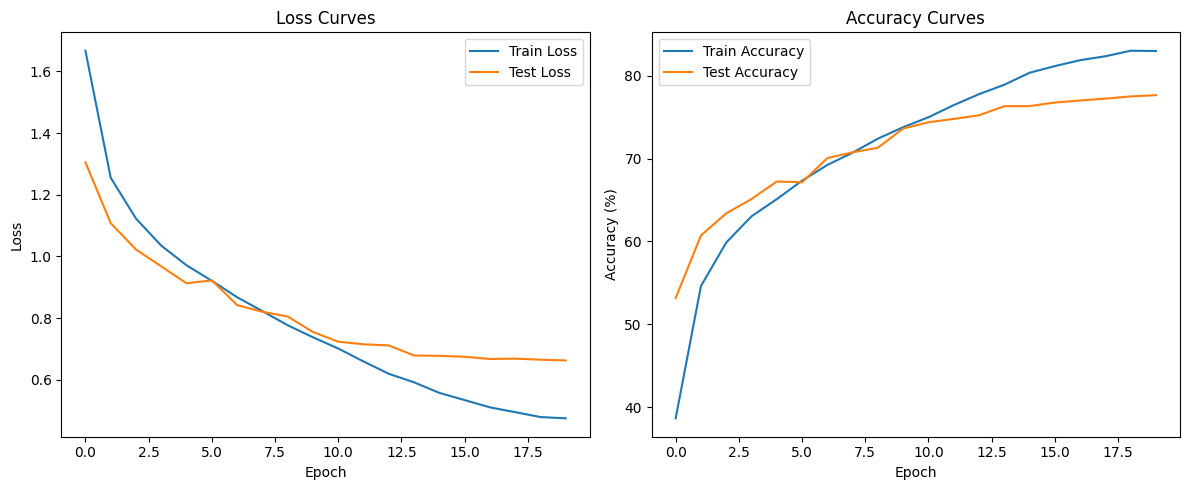

Training complete. Model saved to vit_cifar10_1_3.pth


In [ ]:
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
criterion = nn.CrossEntropyLoss()

# Training loop
train_losses = []
train_accs = []
test_losses = []
test_accs = []

def train_one_epoch(model, train_loader, optimizer, criterion, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
    for batch_idx, (inputs, targets) in enumerate(pbar):
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        # Update progress bar
        pbar.set_postfix({
            'loss': running_loss / (batch_idx + 1),
            'acc': 100. * correct / total
        })
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    
    return train_loss, train_acc

def test(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Statistics
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    test_loss = running_loss / len(test_loader)
    test_acc = 100. * correct / total
    
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
    
    return test_loss, test_acc

# Main training loop
for epoch in range(num_epochs):
    # Train
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, epoch)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Test
    test_loss, test_acc = test(model, test_loader, criterion)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
    # Update learning rate
    scheduler.step()
    
    print(f'Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

# Plot training and testing curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy Curves')

plt.tight_layout()
plt.savefig('vit_training_curves.png')
plt.show()

# Save the model
# torch.save(model.state_dict(), 'vit_cifar10_1_3.pth')
print('Training complete. Model saved to vit_cifar10_1_3.pth')

In [2]:
import torch
import torch.nn as nn
import numpy as np
import torch.fft as fft

class FrequencyPixelAttacks(nn.Module):
    """
    A PyTorch transform to apply various frequency-based and pixel-based attacks.
    """
    def __init__(self, attack_type='phase', epsilon=0.1, frequency_radius=0.1, num_pixels=100, noise_std=0.05, seed=None):
        super(FrequencyPixelAttacks, self).__init__()
        self.attack_type = attack_type
        self.epsilon = epsilon
        self.frequency_radius = frequency_radius
        self.num_pixels = num_pixels
        self.noise_std = noise_std
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)
    
    def forward(self, img):
        perturbed_img = img.clone().detach()
        if self.attack_type == 'phase':
            perturbed_img = self._phase_attack(perturbed_img)
        elif self.attack_type == 'magnitude':
            perturbed_img = self._magnitude_attack(perturbed_img)
        elif self.attack_type == 'low_freq':
            perturbed_img = self._low_frequency_attack(perturbed_img)
        elif self.attack_type == 'high_freq':
            perturbed_img = self._high_frequency_attack(perturbed_img)
        elif self.attack_type == 'pixel':
            perturbed_img = self._pixel_attack(perturbed_img)
        elif self.attack_type == 'normal':
            perturbed_img = self._normal_noise_attack(perturbed_img)
        else:
            raise ValueError(f"Unknown attack type: {self.attack_type}")
        return torch.clamp(perturbed_img, 0, 1)
    
    def _phase_attack(self, img):
        batch, channels, height, width = img.shape
        perturbed_img = torch.zeros_like(img)
        for c in range(channels):
            f_transform = fft.fftshift(fft.fft2(img[:, c]))
            magnitude = torch.abs(f_transform)
            phase = torch.angle(f_transform)
            phase_noise = torch.randn_like(phase) * self.epsilon
            perturbed_phase = phase + phase_noise
            f_transform_perturbed = magnitude * torch.exp(1j * perturbed_phase)
            img_perturbed = fft.ifft2(fft.ifftshift(f_transform_perturbed)).real
            perturbed_img[:, c] = img_perturbed
        return perturbed_img
    
    def _magnitude_attack(self, img):
        batch, channels, height, width = img.shape
        perturbed_img = torch.zeros_like(img)
        for c in range(channels):
            f_transform = fft.fftshift(fft.fft2(img[:, c]))
            magnitude = torch.abs(f_transform)
            phase = torch.angle(f_transform)
            magnitude_noise = torch.randn_like(magnitude) * self.epsilon * magnitude
            perturbed_magnitude = magnitude + magnitude_noise
            f_transform_perturbed = perturbed_magnitude * torch.exp(1j * phase)
            img_perturbed = fft.ifft2(fft.ifftshift(f_transform_perturbed)).real
            perturbed_img[:, c] = img_perturbed
        return perturbed_img
    
    def _create_frequency_mask(self, height, width, is_low_freq=True):
        y_indices, x_indices = torch.meshgrid(torch.arange(height), torch.arange(width), indexing='ij')
        y_indices = y_indices - height // 2
        x_indices = x_indices - width // 2
        distance = torch.sqrt(y_indices**2 + x_indices**2).float()
        max_distance = torch.sqrt(torch.tensor(height**2 + width**2, dtype=torch.float32))
        distance /= max_distance
        return (distance <= self.frequency_radius).float() if is_low_freq else (distance >= (1 - self.frequency_radius)).float()
    
    def _low_frequency_attack(self, img):
        batch, channels, height, width = img.shape
        perturbed_img = torch.zeros_like(img)
        mask = self._create_frequency_mask(height, width, is_low_freq=True).to(img.device)
        for c in range(channels):
            f_transform = fft.fftshift(fft.fft2(img[:, c]))
            noise = (torch.randn_like(f_transform.real) + 1j * torch.randn_like(f_transform.imag)) * self.epsilon
            f_transform_perturbed = f_transform + noise * mask
            img_perturbed = fft.ifft2(fft.ifftshift(f_transform_perturbed)).real
            perturbed_img[:, c] = img_perturbed
        return perturbed_img
    
    def _high_frequency_attack(self, img):
        batch, channels, height, width = img.shape
        perturbed_img = torch.zeros_like(img)
        mask = self._create_frequency_mask(height, width, is_low_freq=False).to(img.device)
        for c in range(channels):
            f_transform = fft.fftshift(fft.fft2(img[:, c]))
            noise = (torch.randn_like(f_transform.real) + 1j * torch.randn_like(f_transform.imag)) * self.epsilon
            f_transform_perturbed = f_transform + noise * mask
            img_perturbed = fft.ifft2(fft.ifftshift(f_transform_perturbed)).real
            perturbed_img[:, c] = img_perturbed
        return perturbed_img
    
    def _pixel_attack(self, img):
        batch, channels, height, width = img.shape
        perturbed_img = img.clone()
        num_pixels = min(self.num_pixels, height * width)
        pixel_indices = torch.randint(0, height * width, (batch, num_pixels))
        y_indices, x_indices = pixel_indices // width, pixel_indices % width
        for b in range(batch):
            for c in range(channels):
                for i in range(num_pixels):
                    perturbed_img[b, c, y_indices[b, i], x_indices[b, i]] += torch.randn(1).item() * self.epsilon
        return perturbed_img
    
    def _normal_noise_attack(self, img):
        noise = torch.randn_like(img) * self.noise_std
        return img + noise

def display_image(original, adversarial):
    """Display last batch of original and adversarial images."""
    fig, axes = plt.subplots(2, len(original), figsize=(16, 10))
    
    for i in range(len(original)):
        orig_img = original[i].permute(1, 2, 0).cpu().numpy()
        adv_img = adversarial[i].permute(1, 2, 0).cpu().numpy()
        
        orig_img = np.clip(orig_img, 0, 1)
        adv_img = np.clip(adv_img, 0, 1)

        
        axes[0, i].imshow(orig_img)
        axes[0, i].axis("off")

        axes[1, i].imshow(adv_img)
        axes[1, i].axis("off")

    plt.show()


def train_adversary(model):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 1. Freeze the model (so only adversary parameters are updated)
    for param in model.parameters():
        param.requires_grad = False
    model.eval()
    
    # 2. Evaluate adversarial attack on test data
    # _, test_loader, _ = load_dataset(
    #     dataset_name='cifar10', 
    #     batch_size=1, 
    #     img_size=32
    # )
    test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
    
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)
    
    # test_loader = load_pets_test(batch_size=1)  # Load test dataset
    test_dataset = test_loader.dataset  # Get dataset without batching

    attacks = [
        {'attack_type': 'phase', 'epsilon': 0.1, 'frequency_radius': 0.1, 'num_pixels': 100, 'noise_std': 0.05, 'name': 'phase_weak'},
        {'attack_type': 'phase', 'epsilon': 0.5, 'frequency_radius': 0.1, 'num_pixels': 100, 'noise_std': 0.05, 'name': 'phase_strong'},
        {'attack_type': 'magnitude', 'epsilon': 0.1, 'frequency_radius': 0.1, 'num_pixels': 100, 'noise_std': 0.05, 'name': 'magnitude_weak'},
        {'attack_type': 'magnitude', 'epsilon': 0.5, 'frequency_radius': 0.1, 'num_pixels': 100, 'noise_std': 0.05, 'name': 'magnitude_strong'},
        # {'attack_type': 'low_freq', 'epsilon': 0.2, 'frequency_radius': 0.1, 'num_pixels': 100, 'noise_std': 0.05, 'name': 'low_freq_small_radius'},
        # {'attack_type': 'low_freq', 'epsilon': 0.2, 'frequency_radius': 0.3, 'num_pixels': 100, 'noise_std': 0.05, 'name': 'low_freq_large_radius'},
        # {'attack_type': 'high_freq', 'epsilon': 0.2, 'frequency_radius': 0.1, 'num_pixels': 100, 'noise_std': 0.05, 'name': 'high_freq_small_radius'},
        # {'attack_type': 'high_freq', 'epsilon': 0.2, 'frequency_radius': 0.3, 'num_pixels': 100, 'noise_std': 0.05, 'name': 'high_freq_large_radius'},
        {'attack_type': 'normal', 'epsilon': 0.1,  'frequency_radius': 0.1, 'num_pixels': 100, 'noise_std': 0.05, 'name': 'normal_weak'},
        {'attack_type': 'normal', 'epsilon': 0.1, 'frequency_radius': 0.1, 'num_pixels': 100, 'noise_std': 0.2, 'name': 'normal_strong'},
        # {'attack_type': 'pixel', 'epsilon': 0.5, 'frequency_radius': 0.1, 'num_pixels': 100, 'noise_std': 0.05, 'name': 'pixel_few'},
        # {'attack_type': 'pixel', 'epsilon': 0.5, 'frequency_radius': 0.1, 'num_pixels': 1000, 'noise_std': 0.05, 'name': 'pixel_many'}
    ]

    for attack in attacks:
        total_correct_original = 0
        total_correct_perturbed = 0
        total_samples = 0
        last_batch_images = []
        last_batch_perturbed = []
        
        adversary = FrequencyPixelAttacks(attack["attack_type"], attack["epsilon"], attack["frequency_radius"], attack["num_pixels"], attack["noise_std"])

        # Process each image individually
        for i in range(len(test_dataset)):
            image, label = test_dataset[i]  # Get single image and label
            image, label = image.to(device).unsqueeze(0), torch.tensor([label]).to(device)  # Add batch dimension

            # image = image.squeeze(0)  # Removes the batch dimension
            perturbed_image = adversary(image)
            
            with torch.no_grad():
                y_hat = model(image)
                y_pred = model(perturbed_image)
            
            pred_original = torch.argmax(y_hat, dim=1)
            pred_perturbed = torch.argmax(y_pred, dim=1)
            
            total_correct_original += (pred_original == label).item()
            total_correct_perturbed += (pred_perturbed == label).item()
            total_samples += 1  # Each image is processed individually
            
            if i < 5:  # Store only a few images for visualization
                last_batch_images.append(image.cpu().squeeze(0))
                last_batch_perturbed.append(perturbed_image.cpu().squeeze(0))

        original_acc = (total_correct_original / total_samples) * 100
        perturbed_acc = (total_correct_perturbed / total_samples) * 100
    
        print(f"Attack: {attack['name']}")
        print("Total Samples: ", total_samples)
        print(f"Accuracy on Original Images: {original_acc:.2f}%")
        print(f"Accuracy on Perturbed Images: {perturbed_acc:.2f}%")

        display_image(last_batch_images, last_batch_perturbed)

Attack: phase_weak
Total Samples:  10000
Accuracy on Original Images: 77.67%
Accuracy on Perturbed Images: 42.61%


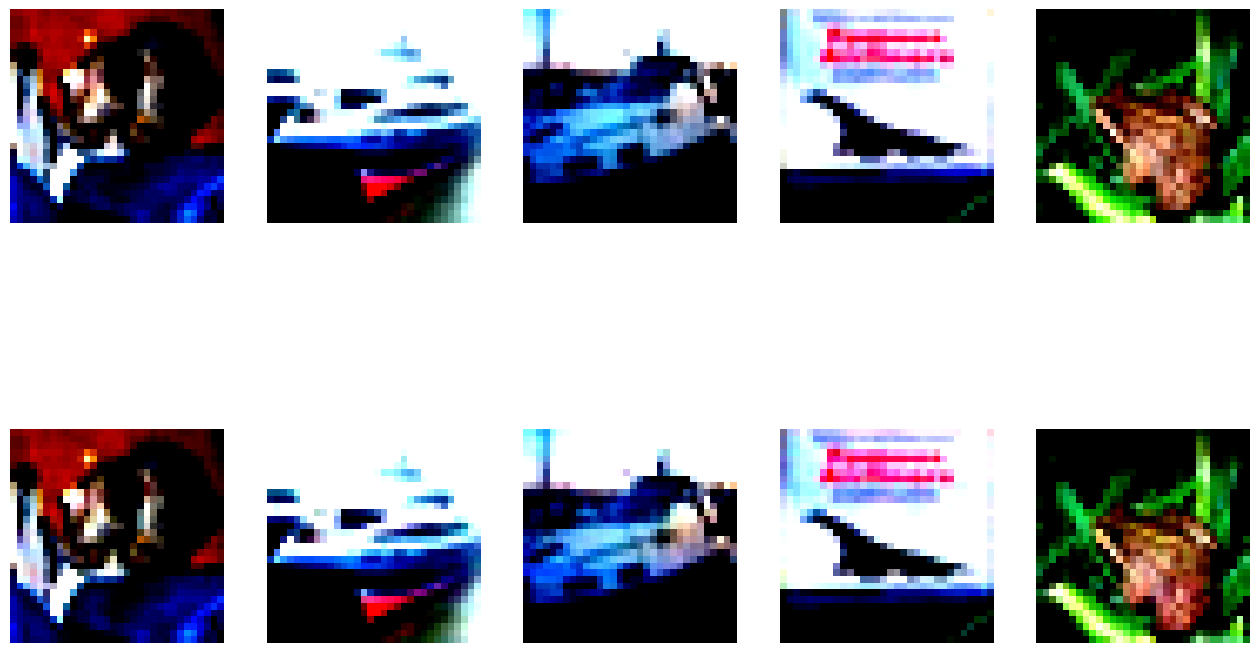

Attack: phase_strong
Total Samples:  10000
Accuracy on Original Images: 77.67%
Accuracy on Perturbed Images: 33.18%


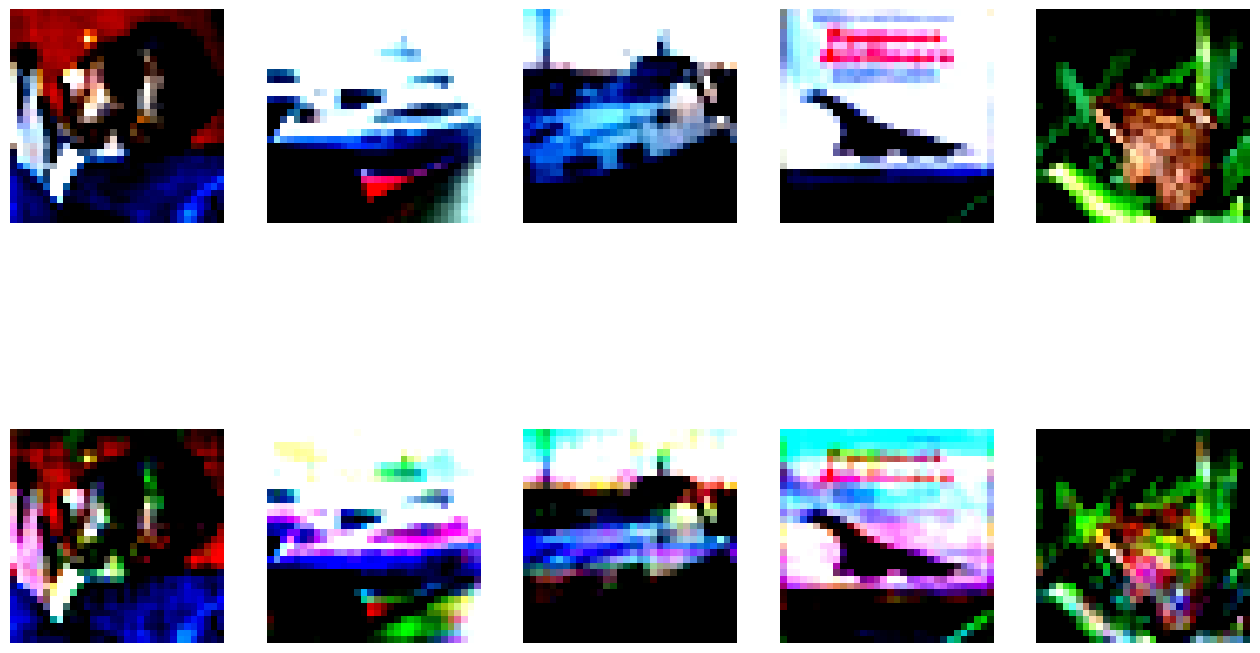

Attack: magnitude_weak
Total Samples:  10000
Accuracy on Original Images: 77.67%
Accuracy on Perturbed Images: 42.33%


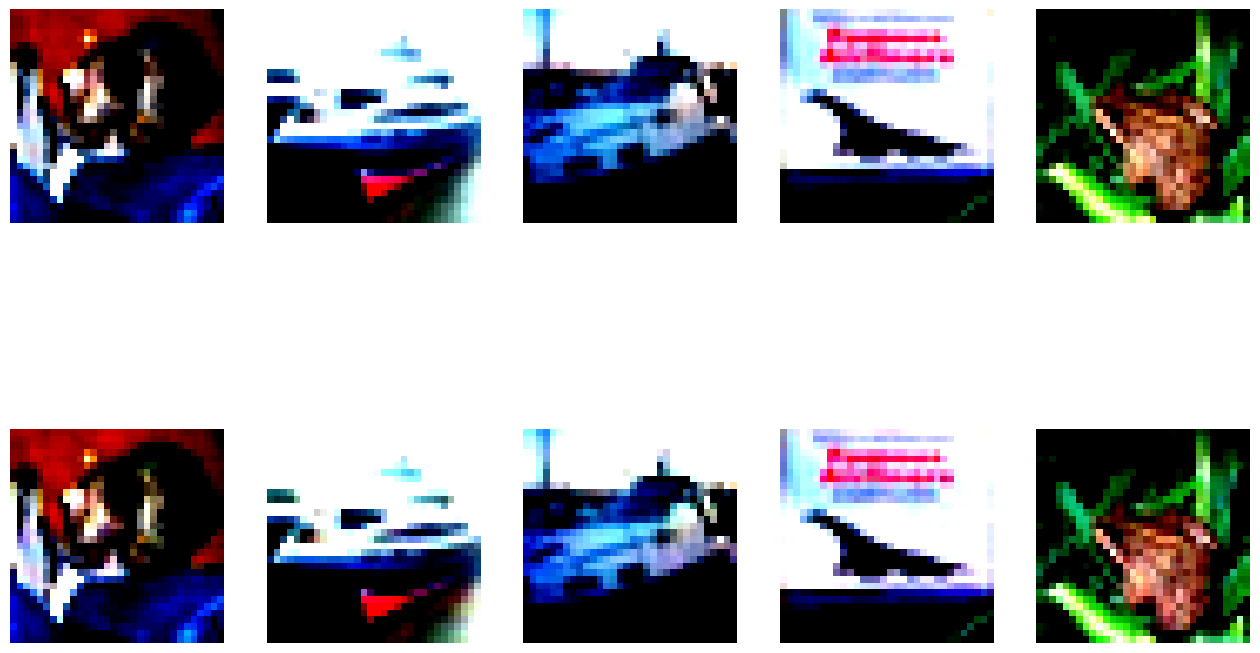

Attack: magnitude_strong
Total Samples:  10000
Accuracy on Original Images: 77.67%
Accuracy on Perturbed Images: 32.76%


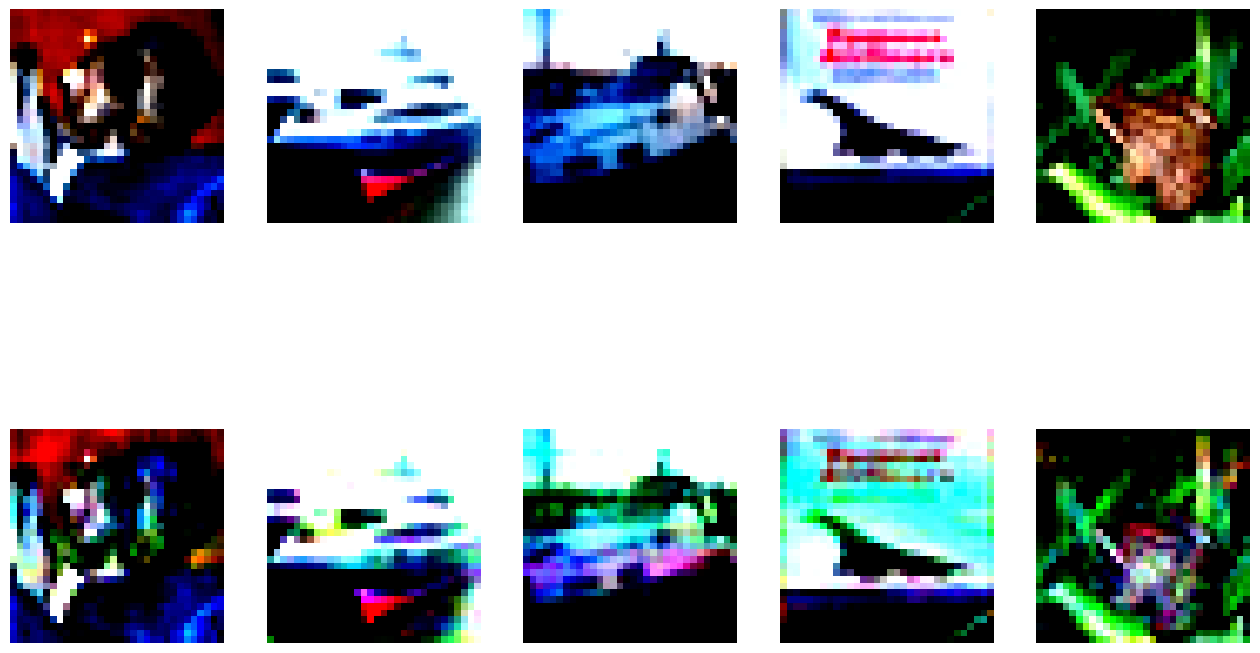

Attack: normal_weak
Total Samples:  10000
Accuracy on Original Images: 77.67%
Accuracy on Perturbed Images: 43.48%


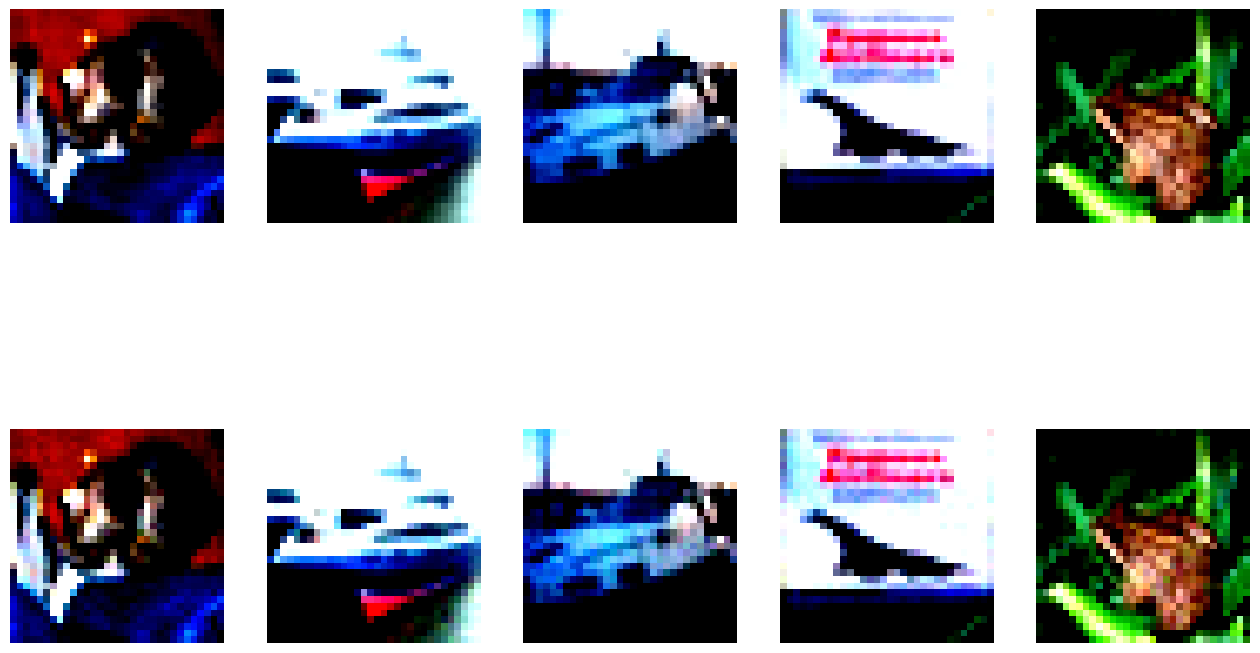

Attack: normal_strong
Total Samples:  10000
Accuracy on Original Images: 77.67%
Accuracy on Perturbed Images: 41.87%


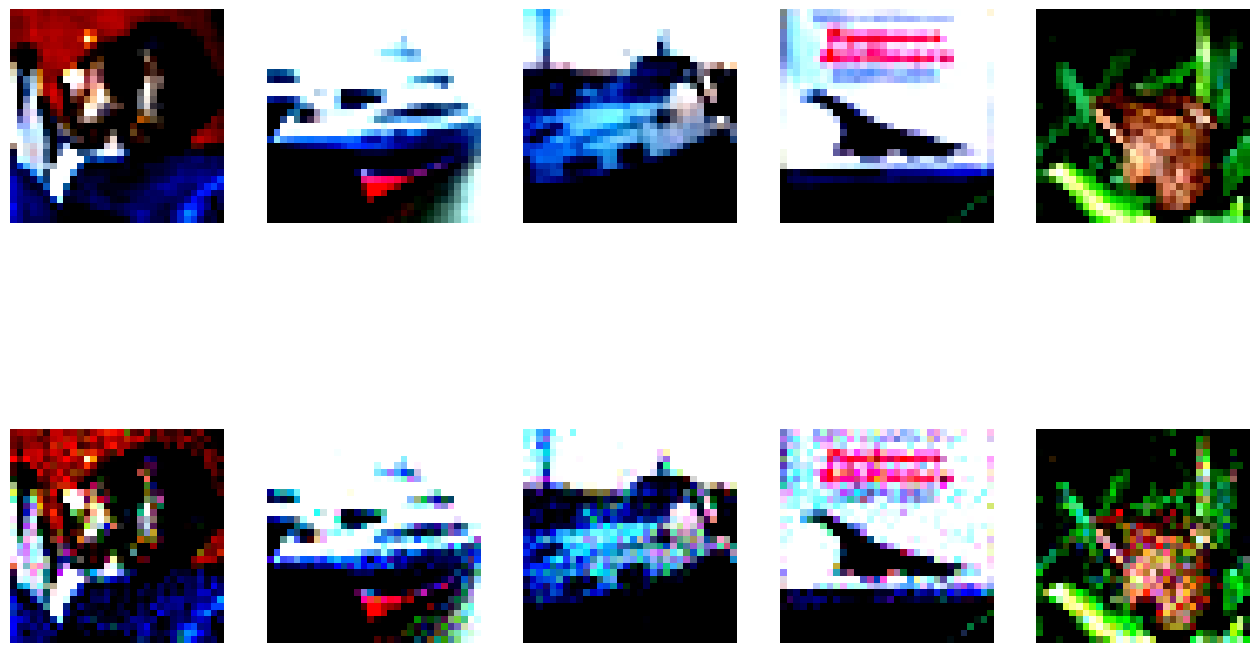

In [3]:
train_adversary(model)